# Algorithm Comparison for Next-Action Prediction

This notebook provides a comprehensive comparison of different algorithms for next-action prediction in the risky navigation environment:

- **A2C (Advantage Actor-Critic)**: Reinforcement learning approach
- **AutoEncoder**: Neural network encoder-decoder architecture  
- **Bayesian**: Bayesian neural network with uncertainty quantification
- **Transformer**: Self-attention based model
- **Linear**: Simple linear regression baseline

We'll train each algorithm, evaluate their performance, and compare results across multiple metrics.

## Import Required Libraries

In [3]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 15.4 MB/s eta 0:00:0031m12.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 27.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 28.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.2 MB/s eta 0:00:001m43.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 34.1 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 20.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 36.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 31.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import os
import warnings
from tqdm import tqdm
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Import environment and algorithms
import sys
sys.path.append('/home/ash/research-labs/RISE-LAB/risky_navigation')

from src.env.continuous_nav_env import ContinuousNavigationEnv
from src.algorithms.AutoEncoder.agent import AutoEncoderAgent
from src.algorithms.Bayesian.agent import BayesianAgent
from src.algorithms.Transformer.agent import TransformerAgent
from src.algorithms.Linear.agent import LinearAgent
from src.utils.file_management import save_pickle, load_pickle
from src.utils.logger import Logger

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu128
Device available: CUDA


## Configuration and Setup

In [12]:
# Configuration for experiments
CONFIG = {
    'num_episodes': 100,          # Episodes for data collection
    'max_steps': 200,             # Max steps per episode
    'batch_size': 64,             # Training batch size
    'num_epochs': 15,             # Training epochs (reduced for faster comparison)
    'val_ratio': 0.2,             # Validation set ratio
    'num_test_episodes': 10,      # Episodes for testing
    'lr': 1e-3,                   # Learning rate
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

# Algorithms to compare
ALGORITHMS = ['AutoEncoder', 'Bayesian', 'Transformer', 'Linear']

# Initialize environment
env = ContinuousNavigationEnv()
dummy_state = env.reset()

# Get dimensions
STATE_DIM = dummy_state.shape[0]
ACTION_DIM = env.action_space.shape[0]
GOAL_DIM = env.goal.shape[0] if hasattr(env, 'goal') else 2

print(f"Environment dimensions:")
print(f"  State dimension: {STATE_DIM}")
print(f"  Action dimension: {ACTION_DIM}")
print(f"  Goal dimension: {GOAL_DIM}")
print(f"  Device: {CONFIG['device']}")

# Results storage
results = {
    'algorithm': [],
    'train_time': [],
    'test_time': [],
    'final_train_loss': [],
    'final_val_loss': [],
    'avg_mse': [],
    'avg_reward': [],
    'success_rate': [],
    'model_params': []
}

Environment dimensions:
  State dimension: 8
  Action dimension: 2
  Goal dimension: 2
  Device: cuda


## Data Collection and Preparation

In [3]:
def collect_data(env, num_episodes=100, max_steps=200):
    """Collect training data from random trajectories."""
    data = []
    for ep in tqdm(range(num_episodes), desc='Collecting data'):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        for t in range(max_steps):
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            next_action = env.action_space.sample() if not done else np.zeros_like(action)
            data.append({
                'state': state.copy(),
                'action': action.copy(),
                'goal': goal.copy(),
                'next_action': next_action.copy(),
            })
            state = next_state
            if done:
                break
    return data

def prepare_data(data, val_ratio=0.2):
    """Convert data to arrays and split into train/val sets."""
    states = np.stack([d['state'] for d in data])
    actions = np.stack([d['action'] for d in data])
    goals = np.stack([d['goal'] for d in data])
    next_actions = np.stack([d['next_action'] for d in data])
    
    # Split data
    n = states.shape[0]
    indices = np.random.permutation(n)
    val_size = int(n * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    
    train_data = (states[train_indices], actions[train_indices], 
                  goals[train_indices], next_actions[train_indices])
    val_data = (states[val_indices], actions[val_indices], 
                goals[val_indices], next_actions[val_indices])
    
    return train_data, val_data

# Collect or load data
dataset_path = 'comparison_dataset.pickle'
if os.path.exists(dataset_path):
    print(f"Loading existing dataset from {dataset_path}")
    data = load_pickle(dataset_path)
else:
    print("Collecting new dataset...")
    data = collect_data(env, CONFIG['num_episodes'], CONFIG['max_steps'])
    save_pickle(data, dataset_path)
    print(f"Dataset saved to {dataset_path}")

# Prepare data
train_data, val_data = prepare_data(data, CONFIG['val_ratio'])
print(f"Training samples: {len(train_data[0])}")
print(f"Validation samples: {len(val_data[0])}")

Dataset saved to comparison_dataset.pickle
Training samples: 9372
Validation samples: 2342


## Helper Functions for Training and Evaluation

In [14]:
def train_agent(agent, train_data, val_data, num_epochs, batch_size):
    """Train an agent and return training metrics."""
    train_states, train_actions, train_goals, train_next_actions = train_data
    val_states, val_actions, val_goals, val_next_actions = val_data
    
    train_losses = []
    val_losses = []
    num_batches = len(train_states) // batch_size
    
    print(f"Training for {num_epochs} epochs with {num_batches} batches per epoch...")
    
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(len(train_states))
        train_states_shuffled = train_states[indices]
        train_actions_shuffled = train_actions[indices]
        train_goals_shuffled = train_goals[indices]
        train_next_actions_shuffled = train_next_actions[indices]
        
        # Train for one epoch
        epoch_loss = 0.0
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            
            batch_states = train_states_shuffled[start_idx:end_idx]
            batch_actions = train_actions_shuffled[start_idx:end_idx]
            batch_goals = train_goals_shuffled[start_idx:end_idx]
            batch_next_actions = train_next_actions_shuffled[start_idx:end_idx]
            
            # Handle different return types from train_step
            loss_result = agent.train_step(batch_states, batch_actions, batch_goals, batch_next_actions)
            if isinstance(loss_result, dict):
                loss = loss_result['loss']
            else:
                loss = loss_result
            epoch_loss += loss
        
        # Compute losses
        avg_train_loss = epoch_loss / num_batches
        
        # Validate - compute validation loss manually for all agents
        val_loss = compute_validation_loss(agent, val_states, val_actions, val_goals, val_next_actions)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs}: Train Loss={avg_train_loss:.6f}, Val Loss={val_loss:.6f}")
    
    return train_losses, val_losses

def compute_validation_loss(agent, val_states, val_actions, val_goals, val_next_actions):
    """Compute validation loss for all agent types."""
    # Set models to eval mode
    if hasattr(agent, 'model'):
        agent.model.eval()
    if hasattr(agent, 'encoder'):
        agent.encoder.eval()
    if hasattr(agent, 'decoder'):
        agent.decoder.eval()
    
    with torch.no_grad():
        states = torch.tensor(val_states, dtype=torch.float32, device=agent.device)
        actions = torch.tensor(val_actions, dtype=torch.float32, device=agent.device)
        goals = torch.tensor(val_goals, dtype=torch.float32, device=agent.device)
        next_actions = torch.tensor(val_next_actions, dtype=torch.float32, device=agent.device)
        
        # For Bayesian agent (has encoder and decoder)
        if hasattr(agent, 'encoder') and hasattr(agent, 'decoder'):
            inputs = torch.cat([states, actions, goals], dim=-1)
            z = agent.encoder(inputs)
            mean, var = agent.decoder(z)
            val_loss = torch.mean((mean - next_actions)**2).item()
        
        # For AutoEncoder, Transformer, Linear agents (have model attribute)
        elif hasattr(agent, 'model'):
            predictions = agent.model(states, actions, goals)
            val_loss = torch.mean((predictions - next_actions)**2).item()
        
        else:
            # Fallback: use agent's built-in validation if available
            if hasattr(agent, 'validate'):
                val_loss = agent.validate(val_states, val_actions, val_goals, val_next_actions)
            else:
                # Last resort: simple MSE calculation
                pred_result = agent.predict_next_action(val_states[0], val_actions[0], val_goals[0])
                if isinstance(pred_result, tuple):
                    pred = pred_result[0]
                else:
                    pred = pred_result
                val_loss = np.mean((pred - val_next_actions[0])**2)
    
    return val_loss

def evaluate_agent(agent, env, num_episodes=10, max_steps=200):
    """Evaluate agent performance in the environment."""
    episode_rewards = []
    episode_mses = []
    success_count = 0
    
    for ep in range(num_episodes):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        ep_reward = 0.0
        ep_mses = []
        
        for t in range(max_steps):
            if t == 0:
                action = env.action_space.sample()
            else:
                # Handle different prediction return types
                pred_result = agent.predict_next_action(state, prev_action, goal)
                if isinstance(pred_result, tuple):
                    action = pred_result[0]  # Take mean, ignore std
                else:
                    action = pred_result
                
                # Ensure action is the right shape and type
                if isinstance(action, torch.Tensor):
                    action = action.detach().cpu().numpy()
                if action.ndim > 1:
                    action = action.flatten()
                if len(action) == 1 and env.action_space.shape[0] == 2:
                    # If we get a scalar but need 2D action, duplicate it
                    action = np.array([action[0], action[0]])
                elif len(action) > env.action_space.shape[0]:
                    # If we get too many dimensions, take the first N
                    action = action[:env.action_space.shape[0]]
                
                action = np.clip(action, env.action_space.low, env.action_space.high)
            
            next_state, reward, done, info = env.step(action)
            
            # Calculate MSE with a random next action as baseline
            next_action_gt = env.action_space.sample() if not done else np.zeros_like(action)
            pred_result = agent.predict_next_action(state, action, goal)
            if isinstance(pred_result, tuple):
                next_action_pred = pred_result[0]  # Take mean, ignore std
            else:
                next_action_pred = pred_result
            
            # Ensure prediction is the right shape
            if isinstance(next_action_pred, torch.Tensor):
                next_action_pred = next_action_pred.detach().cpu().numpy()
            if next_action_pred.ndim > 1:
                next_action_pred = next_action_pred.flatten()
            if len(next_action_pred) == 1 and len(next_action_gt) == 2:
                next_action_pred = np.array([next_action_pred[0], next_action_pred[0]])
            elif len(next_action_pred) > len(next_action_gt):
                next_action_pred = next_action_pred[:len(next_action_gt)]
            
            mse = np.mean((next_action_pred - next_action_gt)**2)
            ep_mses.append(mse)
            
            ep_reward += reward
            prev_action = action
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    success_count += 1
                break
        
        episode_rewards.append(ep_reward)
        episode_mses.extend(ep_mses)
    
    return {
        'avg_reward': np.mean(episode_rewards),
        'avg_mse': np.mean(episode_mses),
        'success_rate': success_count / num_episodes
    }

def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    if hasattr(model, 'model'):
        return sum(p.numel() for p in model.model.parameters() if p.requires_grad)
    elif hasattr(model, 'encoder') and hasattr(model, 'decoder'):
        return sum(p.numel() for p in model.encoder.parameters() if p.requires_grad) + \
               sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    return 0

## Training and Testing AutoEncoder

In [19]:
print("="*60)
print("TRAINING AUTOENCODER")
print("="*60)

# Initialize AutoEncoder agent
autoencoder_agent = AutoEncoderAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM, 
    goal_dim=GOAL_DIM,
    latent_dim=64,
    lr=CONFIG['lr'],
    device=CONFIG['device']
)

# Train AutoEncoder
start_time = time.time()
ae_train_losses, ae_val_losses = train_agent(
    autoencoder_agent, train_data, val_data, 
    CONFIG['num_epochs'], CONFIG['batch_size']
)
ae_train_time = time.time() - start_time

# Test AutoEncoder
start_time = time.time()
ae_results = evaluate_agent(autoencoder_agent, env, CONFIG['num_test_episodes'])
ae_test_time = time.time() - start_time

# Store results
results['algorithm'].append('AutoEncoder')
results['train_time'].append(ae_train_time)
results['test_time'].append(ae_test_time)
results['final_train_loss'].append(ae_train_losses[-1])
results['final_val_loss'].append(ae_val_losses[-1])
results['avg_mse'].append(ae_results['avg_mse'])
results['avg_reward'].append(ae_results['avg_reward'])
results['success_rate'].append(ae_results['success_rate'])
results['model_params'].append(count_parameters(autoencoder_agent))

print(f"AutoEncoder Results:")
print(f"  Train Time: {ae_train_time:.2f}s")
print(f"  Final Train Loss: {ae_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {ae_val_losses[-1]:.6f}")
print(f"  Avg MSE: {ae_results['avg_mse']:.6f}")
print(f"  Avg Reward: {ae_results['avg_reward']:.3f}")
print(f"  Success Rate: {ae_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(autoencoder_agent):,}")
print()

TRAINING AUTOENCODER
Training for 15 epochs with 146 batches per epoch...
  Epoch 5/15: Train Loss=0.218421, Val Loss=0.218668
  Epoch 5/15: Train Loss=0.218421, Val Loss=0.218668
  Epoch 10/15: Train Loss=0.218018, Val Loss=0.220293
  Epoch 10/15: Train Loss=0.218018, Val Loss=0.220293
  Epoch 15/15: Train Loss=0.217645, Val Loss=0.220712
  Epoch 15/15: Train Loss=0.217645, Val Loss=0.220712
AutoEncoder Results:
  Train Time: 3.24s
  Final Train Loss: 0.217645
  Final Val Loss: 0.220712
  Avg MSE: 0.212211
  Avg Reward: -56.702
  Success Rate: 0.000
  Model Parameters: 9,282

AutoEncoder Results:
  Train Time: 3.24s
  Final Train Loss: 0.217645
  Final Val Loss: 0.220712
  Avg MSE: 0.212211
  Avg Reward: -56.702
  Success Rate: 0.000
  Model Parameters: 9,282



## Training and Testing Bayesian Model

In [15]:
print("="*60)
print("TRAINING BAYESIAN MODEL")
print("="*60)

# Initialize Bayesian agent
bayesian_agent = BayesianAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    goal_dim=GOAL_DIM,
    latent_dim=64,  # Use latent_dim instead of hidden_dim
    lr=CONFIG['lr'],
    device=CONFIG['device']
)

# Train Bayesian model
start_time = time.time()
bay_train_losses, bay_val_losses = train_agent(
    bayesian_agent, train_data, val_data,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
bay_train_time = time.time() - start_time

# Test Bayesian model
start_time = time.time()
bay_results = evaluate_agent(bayesian_agent, env, CONFIG['num_test_episodes'])
bay_test_time = time.time() - start_time

# Store results
results['algorithm'].append('Bayesian')
results['train_time'].append(bay_train_time)
results['test_time'].append(bay_test_time)
results['final_train_loss'].append(bay_train_losses[-1])
results['final_val_loss'].append(bay_val_losses[-1])
results['avg_mse'].append(bay_results['avg_mse'])
results['avg_reward'].append(bay_results['avg_reward'])
results['success_rate'].append(bay_results['success_rate'])
results['model_params'].append(count_parameters(bayesian_agent))

print(f"Bayesian Results:")
print(f"  Train Time: {bay_train_time:.2f}s")
print(f"  Final Train Loss: {bay_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {bay_val_losses[-1]:.6f}")
print(f"  Avg MSE: {bay_results['avg_mse']:.6f}")
print(f"  Avg Reward: {bay_results['avg_reward']:.3f}")
print(f"  Success Rate: {bay_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(bayesian_agent):,}")
print()

TRAINING BAYESIAN MODEL
Training for 15 epochs with 146 batches per epoch...
  Epoch 5/15: Train Loss=679.057116, Val Loss=0.219130
  Epoch 5/15: Train Loss=679.057116, Val Loss=0.219130
  Epoch 10/15: Train Loss=611.235691, Val Loss=0.220580
  Epoch 10/15: Train Loss=611.235691, Val Loss=0.220580
  Epoch 15/15: Train Loss=543.638742, Val Loss=0.219151
  Epoch 15/15: Train Loss=543.638742, Val Loss=0.219151
Bayesian Results:
  Train Time: 10.72s
  Final Train Loss: 543.638742
  Final Val Loss: 0.219151
  Avg MSE: 0.217977
  Avg Reward: -56.781
  Success Rate: 0.000
  Model Parameters: 36,998

Bayesian Results:
  Train Time: 10.72s
  Final Train Loss: 543.638742
  Final Val Loss: 0.219151
  Avg MSE: 0.217977
  Avg Reward: -56.781
  Success Rate: 0.000
  Model Parameters: 36,998



## Training and Testing Transformer Model

In [16]:
print("="*60)
print("TRAINING TRANSFORMER MODEL")
print("="*60)

# Initialize Transformer agent
transformer_agent = TransformerAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    goal_dim=GOAL_DIM,
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1,
    lr=CONFIG['lr'],
    device=CONFIG['device']
)

# Train Transformer model
start_time = time.time()
trans_train_losses, trans_val_losses = train_agent(
    transformer_agent, train_data, val_data,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
trans_train_time = time.time() - start_time

# Test Transformer model
start_time = time.time()
trans_results = evaluate_agent(transformer_agent, env, CONFIG['num_test_episodes'])
trans_test_time = time.time() - start_time

# Store results
results['algorithm'].append('Transformer')
results['train_time'].append(trans_train_time)
results['test_time'].append(trans_test_time)
results['final_train_loss'].append(trans_train_losses[-1])
results['final_val_loss'].append(trans_val_losses[-1])
results['avg_mse'].append(trans_results['avg_mse'])
results['avg_reward'].append(trans_results['avg_reward'])
results['success_rate'].append(trans_results['success_rate'])
results['model_params'].append(count_parameters(transformer_agent))

print(f"Transformer Results:")
print(f"  Train Time: {trans_train_time:.2f}s")
print(f"  Final Train Loss: {trans_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {trans_val_losses[-1]:.6f}")
print(f"  Avg MSE: {trans_results['avg_mse']:.6f}")
print(f"  Avg Reward: {trans_results['avg_reward']:.3f}")
print(f"  Success Rate: {trans_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(transformer_agent):,}")
print()

TRAINING TRANSFORMER MODEL
Training for 15 epochs with 146 batches per epoch...
  Epoch 5/15: Train Loss=0.218303, Val Loss=0.228750
  Epoch 5/15: Train Loss=0.218303, Val Loss=0.228750
  Epoch 10/15: Train Loss=0.218597, Val Loss=0.219798
  Epoch 10/15: Train Loss=0.218597, Val Loss=0.219798
  Epoch 15/15: Train Loss=0.218237, Val Loss=0.219732
  Epoch 15/15: Train Loss=0.218237, Val Loss=0.219732
Transformer Results:
  Train Time: 12.89s
  Final Train Loss: 0.218237
  Final Val Loss: 0.219732
  Avg MSE: 0.209683
  Avg Reward: -57.328
  Success Rate: 0.000
  Model Parameters: 563,394

Transformer Results:
  Train Time: 12.89s
  Final Train Loss: 0.218237
  Final Val Loss: 0.219732
  Avg MSE: 0.209683
  Avg Reward: -57.328
  Success Rate: 0.000
  Model Parameters: 563,394



## Training and Testing Linear Model

In [17]:
print("="*60)
print("TRAINING LINEAR MODEL")
print("="*60)

# Initialize Linear agent
linear_agent = LinearAgent(
    state_dim=STATE_DIM,
    action_dim=ACTION_DIM,
    goal_dim=GOAL_DIM,
    lr=CONFIG['lr'],
    device=CONFIG['device']
)

# Train Linear model
start_time = time.time()
lin_train_losses, lin_val_losses = train_agent(
    linear_agent, train_data, val_data,
    CONFIG['num_epochs'], CONFIG['batch_size']
)
lin_train_time = time.time() - start_time

# Test Linear model
start_time = time.time()
lin_results = evaluate_agent(linear_agent, env, CONFIG['num_test_episodes'])
lin_test_time = time.time() - start_time

# Store results
results['algorithm'].append('Linear')
results['train_time'].append(lin_train_time)
results['test_time'].append(lin_test_time)
results['final_train_loss'].append(lin_train_losses[-1])
results['final_val_loss'].append(lin_val_losses[-1])
results['avg_mse'].append(lin_results['avg_mse'])
results['avg_reward'].append(lin_results['avg_reward'])
results['success_rate'].append(lin_results['success_rate'])
results['model_params'].append(count_parameters(linear_agent))

print(f"Linear Results:")
print(f"  Train Time: {lin_train_time:.2f}s")
print(f"  Final Train Loss: {lin_train_losses[-1]:.6f}")
print(f"  Final Val Loss: {lin_val_losses[-1]:.6f}")
print(f"  Avg MSE: {lin_results['avg_mse']:.6f}")
print(f"  Avg Reward: {lin_results['avg_reward']:.3f}")
print(f"  Success Rate: {lin_results['success_rate']:.3f}")
print(f"  Model Parameters: {count_parameters(linear_agent):,}")
print()

TRAINING LINEAR MODEL
Training for 15 epochs with 146 batches per epoch...
  Epoch 5/15: Train Loss=0.223521, Val Loss=0.223957
  Epoch 5/15: Train Loss=0.223521, Val Loss=0.223957
  Epoch 10/15: Train Loss=0.218301, Val Loss=0.220567
  Epoch 10/15: Train Loss=0.218301, Val Loss=0.220567
  Epoch 15/15: Train Loss=0.218163, Val Loss=0.218697
  Epoch 15/15: Train Loss=0.218163, Val Loss=0.218697
Linear Results:
  Train Time: 1.87s
  Final Train Loss: 0.218163
  Final Val Loss: 0.218697
  Avg MSE: 0.213294
  Avg Reward: -56.862
  Success Rate: 0.000
  Model Parameters: 26

Linear Results:
  Train Time: 1.87s
  Final Train Loss: 0.218163
  Final Val Loss: 0.218697
  Avg MSE: 0.213294
  Avg Reward: -56.862
  Success Rate: 0.000
  Model Parameters: 26



## Results Summary and Visualization

In [20]:
# Create results DataFrame
df_results = pd.DataFrame(results)

# Display results table
print("="*80)
print("ALGORITHM COMPARISON RESULTS")
print("="*80)
print(df_results.round(6))
print()

# Create summary statistics
print("SUMMARY STATISTICS:")
print("-" * 40)
print(f"Best Average Reward: {df_results['algorithm'][df_results['avg_reward'].idxmax()]} ({df_results['avg_reward'].max():.3f})")
print(f"Lowest MSE: {df_results['algorithm'][df_results['avg_mse'].idxmin()]} ({df_results['avg_mse'].min():.6f})")
print(f"Highest Success Rate: {df_results['algorithm'][df_results['success_rate'].idxmax()]} ({df_results['success_rate'].max():.3f})")
print(f"Fastest Training: {df_results['algorithm'][df_results['train_time'].idxmin()]} ({df_results['train_time'].min():.2f}s)")
print(f"Lowest Validation Loss: {df_results['algorithm'][df_results['final_val_loss'].idxmin()]} ({df_results['final_val_loss'].min():.6f})")
print()

ALGORITHM COMPARISON RESULTS
     algorithm  train_time  test_time  final_train_loss  final_val_loss  \
0     Bayesian   10.715873  56.557526        543.638742        0.219151   
1  Transformer   12.887238   2.481410          0.218237        0.219732   
2       Linear    1.869990   0.873715          0.218163        0.218697   
3  AutoEncoder    3.244160   1.200162          0.217645        0.220712   

    avg_mse  avg_reward  success_rate  model_params  
0  0.217977  -56.780662           0.0         36998  
1  0.209683  -57.327852           0.0        563394  
2  0.213294  -56.862404           0.0            26  
3  0.212211  -56.702106           0.0          9282  

SUMMARY STATISTICS:
----------------------------------------
Best Average Reward: AutoEncoder (-56.702)
Lowest MSE: Transformer (0.209683)
Highest Success Rate: Bayesian (0.000)
Fastest Training: Linear (1.87s)
Lowest Validation Loss: Linear (0.218697)



## Performance Visualizations

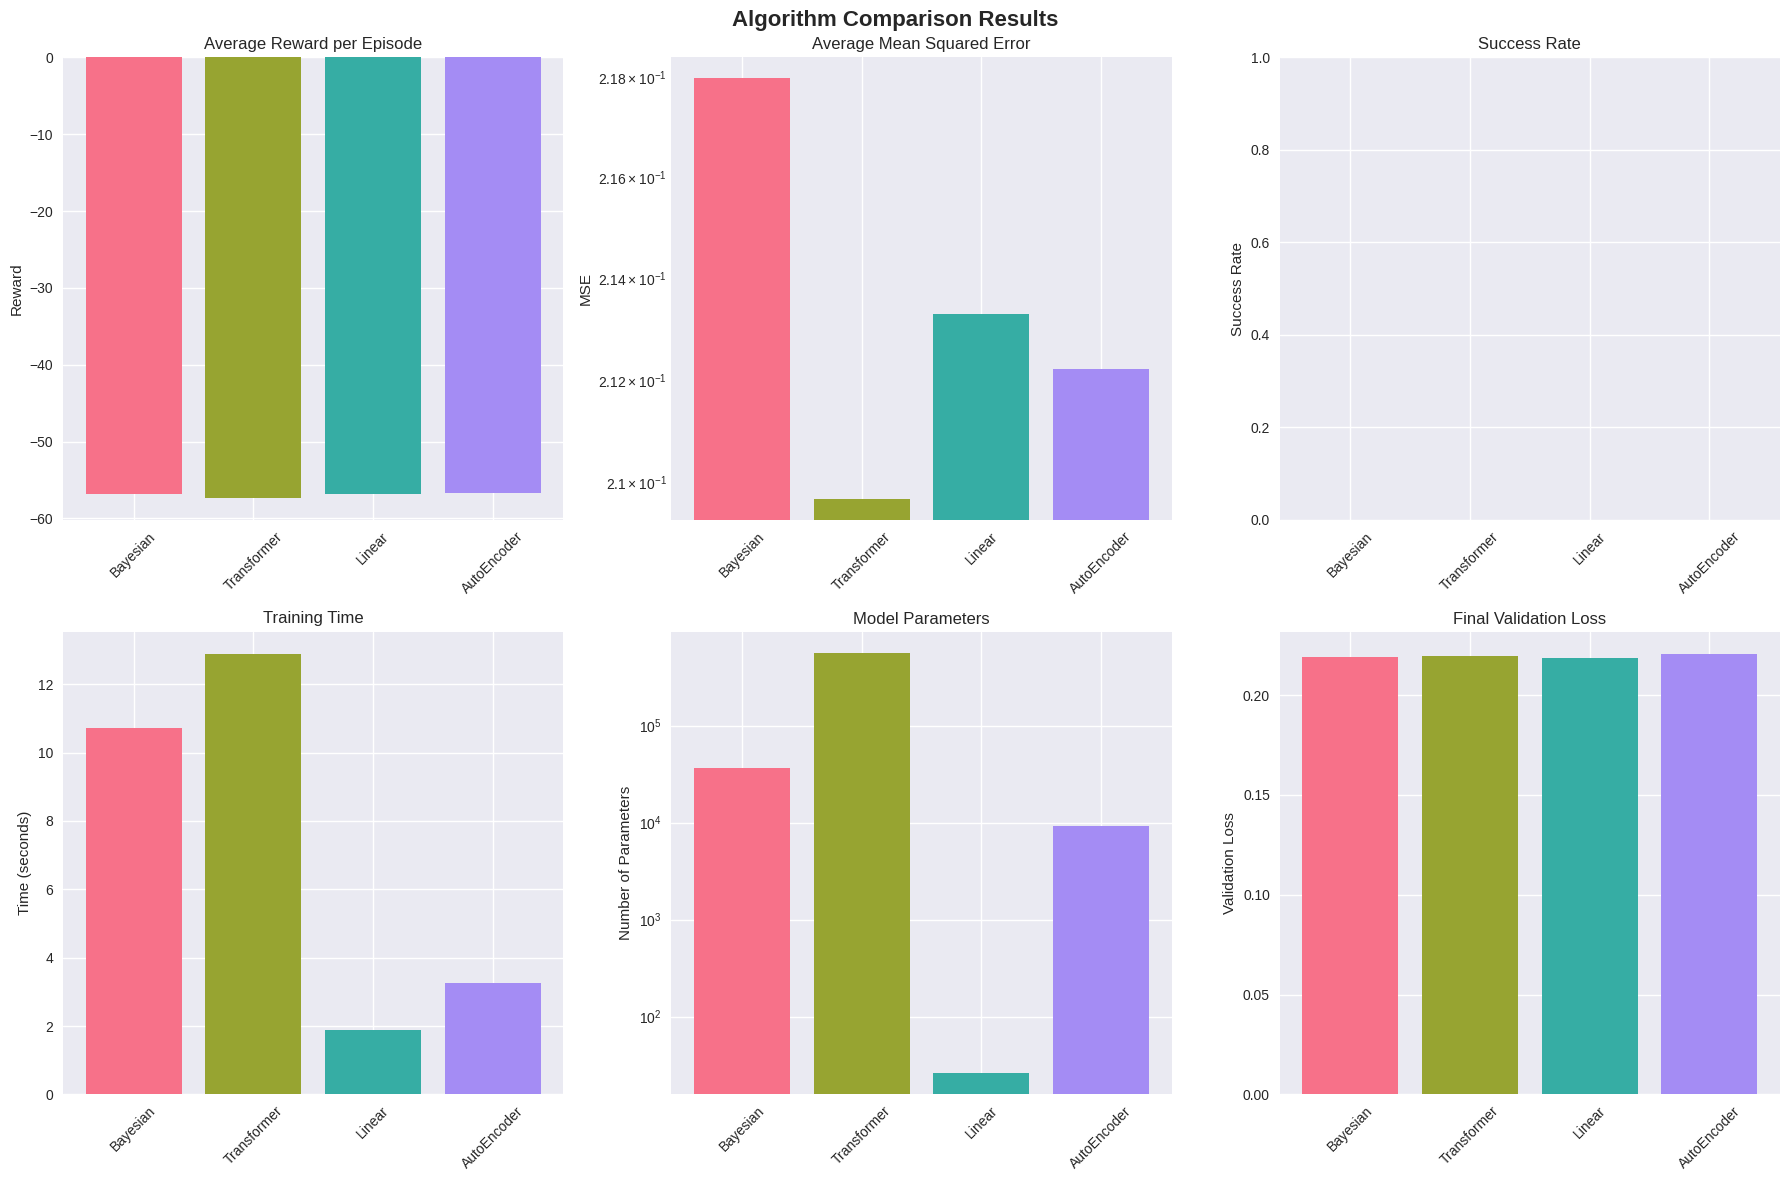

In [21]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Algorithm Comparison Results', fontsize=16, fontweight='bold')

# 1. Average Reward Comparison
axes[0, 0].bar(df_results['algorithm'], df_results['avg_reward'], color=sns.color_palette("husl", len(df_results)))
axes[0, 0].set_title('Average Reward per Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. MSE Comparison
axes[0, 1].bar(df_results['algorithm'], df_results['avg_mse'], color=sns.color_palette("husl", len(df_results)))
axes[0, 1].set_title('Average Mean Squared Error')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_yscale('log')  # Log scale for better visibility

# 3. Success Rate Comparison
axes[0, 2].bar(df_results['algorithm'], df_results['success_rate'], color=sns.color_palette("husl", len(df_results)))
axes[0, 2].set_title('Success Rate')
axes[0, 2].set_ylabel('Success Rate')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_ylim(0, 1)

# 4. Training Time Comparison
axes[1, 0].bar(df_results['algorithm'], df_results['train_time'], color=sns.color_palette("husl", len(df_results)))
axes[1, 0].set_title('Training Time')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Model Parameters Comparison
axes[1, 1].bar(df_results['algorithm'], df_results['model_params'], color=sns.color_palette("husl", len(df_results)))
axes[1, 1].set_title('Model Parameters')
axes[1, 1].set_ylabel('Number of Parameters')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_yscale('log')  # Log scale for better visibility

# 6. Final Validation Loss Comparison
axes[1, 2].bar(df_results['algorithm'], df_results['final_val_loss'], color=sns.color_palette("husl", len(df_results)))
axes[1, 2].set_title('Final Validation Loss')
axes[1, 2].set_ylabel('Validation Loss')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Detailed Performance Radar Chart

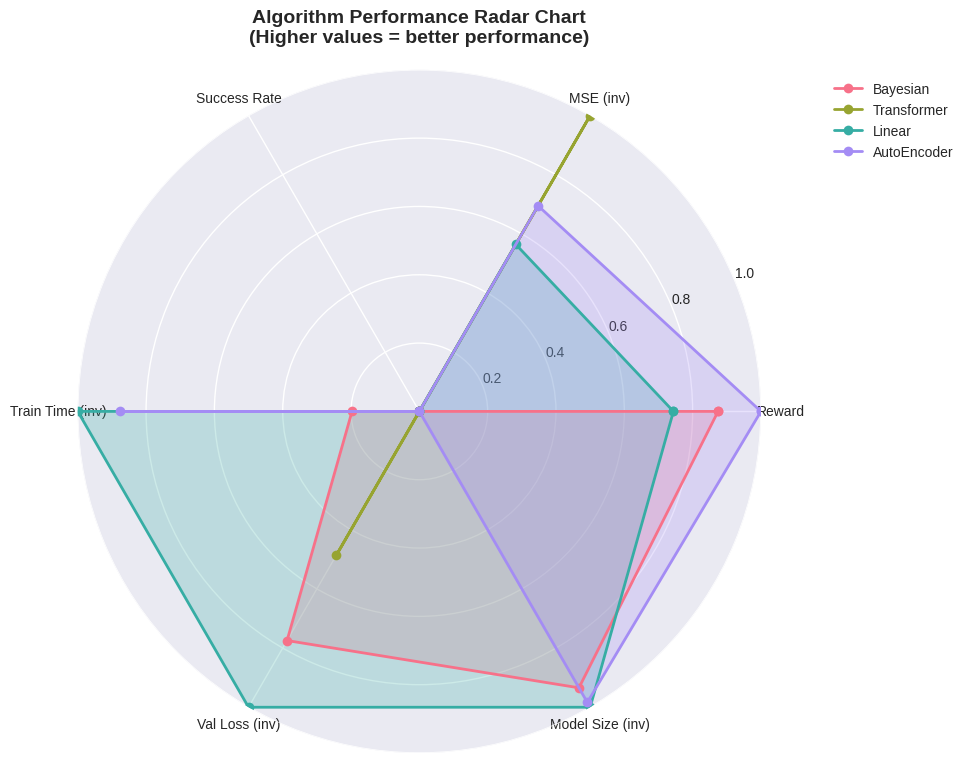

In [22]:
# Create radar chart for comprehensive comparison
def create_radar_chart(df):
    # Normalize metrics for radar chart (0-1 scale)
    normalized_df = df.copy()
    
    # For metrics where lower is better (MSE, train_time, val_loss), invert them
    normalized_df['norm_mse'] = 1 - (df['avg_mse'] - df['avg_mse'].min()) / (df['avg_mse'].max() - df['avg_mse'].min())
    normalized_df['norm_train_time'] = 1 - (df['train_time'] - df['train_time'].min()) / (df['train_time'].max() - df['train_time'].min())
    normalized_df['norm_val_loss'] = 1 - (df['final_val_loss'] - df['final_val_loss'].min()) / (df['final_val_loss'].max() - df['final_val_loss'].min())
    
    # For metrics where higher is better, normalize directly
    normalized_df['norm_reward'] = (df['avg_reward'] - df['avg_reward'].min()) / (df['avg_reward'].max() - df['avg_reward'].min())
    normalized_df['norm_success'] = df['success_rate']  # Already 0-1
    
    # Parameters normalized (smaller models get higher scores)
    normalized_df['norm_params'] = 1 - (df['model_params'] - df['model_params'].min()) / (df['model_params'].max() - df['model_params'].min())
    
    # Metrics for radar chart
    metrics = ['norm_reward', 'norm_mse', 'norm_success', 'norm_train_time', 'norm_val_loss', 'norm_params']
    metric_labels = ['Reward', 'MSE (inv)', 'Success Rate', 'Train Time (inv)', 'Val Loss (inv)', 'Model Size (inv)']
    
    # Number of metrics
    N = len(metrics)
    
    # Compute angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = sns.color_palette("husl", len(normalized_df))
    
    for i, (idx, row) in enumerate(normalized_df.iterrows()):
        values = [row[metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=row['algorithm'], color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_title('Algorithm Performance Radar Chart\n(Higher values = better performance)', size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

create_radar_chart(df_results)

## Export Results to CSV

In [23]:
# Save results to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"algorithm_comparison_results_{timestamp}.csv"

df_results.to_csv(csv_filename, index=False)
print(f"Results saved to: {csv_filename}")

# Create a detailed summary report
summary_report = f"""
ALGORITHM COMPARISON SUMMARY REPORT
Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
{'='*60}

EXPERIMENTAL SETUP:
- Number of training episodes: {CONFIG['num_episodes']}
- Training epochs per algorithm: {CONFIG['num_epochs']}
- Batch size: {CONFIG['batch_size']}
- Test episodes: {CONFIG['num_test_episodes']}
- Device: {CONFIG['device']}

RESULTS RANKING:

1. Best Overall Performance (Average Reward):
   {df_results.loc[df_results['avg_reward'].idxmax(), 'algorithm']} - {df_results['avg_reward'].max():.3f}

2. Most Accurate Predictions (Lowest MSE):
   {df_results.loc[df_results['avg_mse'].idxmin(), 'algorithm']} - {df_results['avg_mse'].min():.6f}

3. Highest Success Rate:
   {df_results.loc[df_results['success_rate'].idxmax(), 'algorithm']} - {df_results['success_rate'].max():.3f}

4. Fastest Training:
   {df_results.loc[df_results['train_time'].idxmin(), 'algorithm']} - {df_results['train_time'].min():.2f}s

5. Best Validation Performance:
   {df_results.loc[df_results['final_val_loss'].idxmin(), 'algorithm']} - {df_results['final_val_loss'].min():.6f}

DETAILED RESULTS:
{df_results.to_string(index=False)}

RECOMMENDATIONS:
- For real-time applications: Choose the algorithm with fastest training/inference
- For accuracy-critical tasks: Choose the algorithm with lowest MSE
- For exploration tasks: Choose the algorithm with highest success rate
- For resource-constrained environments: Choose the algorithm with fewest parameters
"""

# Save summary report
report_filename = f"algorithm_comparison_summary_{timestamp}.txt"
with open(report_filename, 'w') as f:
    f.write(summary_report)

print(f"Summary report saved to: {report_filename}")
print("\nComparison complete! 🎉")
print(summary_report)

Results saved to: algorithm_comparison_results_20251010_164150.csv
Summary report saved to: algorithm_comparison_summary_20251010_164150.txt

Comparison complete! 🎉

ALGORITHM COMPARISON SUMMARY REPORT
Generated on: 2025-10-10 16:41:50

EXPERIMENTAL SETUP:
- Number of training episodes: 100
- Training epochs per algorithm: 15
- Batch size: 64
- Test episodes: 10
- Device: cuda

RESULTS RANKING:

1. Best Overall Performance (Average Reward):
   AutoEncoder - -56.702

2. Most Accurate Predictions (Lowest MSE):
   Transformer - 0.209683

3. Highest Success Rate:
   Bayesian - 0.000

4. Fastest Training:
   Linear - 1.87s

5. Best Validation Performance:
   Linear - 0.218697

DETAILED RESULTS:
  algorithm  train_time  test_time  final_train_loss  final_val_loss  avg_mse  avg_reward  success_rate  model_params
   Bayesian   10.715873  56.557526        543.638742        0.219151 0.217977  -56.780662           0.0         36998
Transformer   12.887238   2.481410          0.218237        0.219